In [1]:
from pathlib import Path
import pyart
import numpy as np



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:

from prepro.nexrad import prune_nexrad
from cappi.make_vv import  get_indexed_vv
from mcit.vil import get_vil_from_azran

#viewable plots
import matplotlib.pyplot as plt
from klaus_krause_cmap import get_obj_cmap
from config import _EXAMPLEDATA_DIR

print(_EXAMPLEDATA_DIR)

/home/john.krause/python/hotspots/exampledata


In [3]:
filename = Path(_EXAMPLEDATA_DIR, "nexrad_level2", "KTLX20230227_012550_V06")
#filename = Path(_EXAMPLEDATA_DIR, "nexrad_level2", "KOAX20140603_213649_V06.gz")
#filename = Path(_EXAMPLEDATA_DIR, "nexrad_level2", "KEWX20210504_020040_V06")
#filename = Path(_EXAMPLEDATA_DIR, "nexrad_level2", "KSHV20230613_230228_V06")

#read in the Level 2 WSR-88D data as a pyart object
radar_vol = pyart.io.read_nexrad_archive(filename)


In [4]:
#remove extra sweeps of data. Keep only data
#from the survelience cuts and one cut per volume 
prune_actions = ['surv', 'volume']
prune_vol = prune_nexrad(prune_actions, radar_vol)



In [5]:
#create an indexed version of the data on 360 radials
#to a range of 1200 (defaults) at 250m gates.
#We also change formats here to an xarray datastore
#working with xarrys is easier for us than pyart objects
ds = get_indexed_vv(prune_vol, fields=['reflectivity'])


2024-12-20 10:56:24,713 [MainThread  ] [INFO ]  1 of 9 current_elev: 0.48
2024-12-20 10:56:24,765 [MainThread  ] [INFO ]  num_sweeps: 9, num_azs: 360, num_gates: 1200
2024-12-20 10:56:24,765 [MainThread  ] [INFO ]  2 of 9 current_elev: 0.88
2024-12-20 10:56:24,816 [MainThread  ] [INFO ]  num_sweeps: 9, num_azs: 360, num_gates: 1200
2024-12-20 10:56:24,817 [MainThread  ] [INFO ]  3 of 9 current_elev: 1.32
2024-12-20 10:56:24,866 [MainThread  ] [INFO ]  num_sweeps: 9, num_azs: 360, num_gates: 1200
2024-12-20 10:56:24,866 [MainThread  ] [INFO ]  4 of 9 current_elev: 1.80
2024-12-20 10:56:24,896 [MainThread  ] [INFO ]  num_sweeps: 9, num_azs: 360, num_gates: 1200
2024-12-20 10:56:24,897 [MainThread  ] [INFO ]  5 of 9 current_elev: 2.42
2024-12-20 10:56:24,926 [MainThread  ] [INFO ]  num_sweeps: 9, num_azs: 360, num_gates: 1200
2024-12-20 10:56:24,926 [MainThread  ] [INFO ]  6 of 9 current_elev: 3.12
2024-12-20 10:56:24,955 [MainThread  ] [INFO ]  num_sweeps: 9, num_azs: 360, num_gates: 120

In [6]:
#compute VIL from the indexed volume of reflectivity
vil = get_vil_from_azran(ds['reflectivity'])
vil.attrs.update(ds.attrs)
#this adds the vil to the xarray dataset we are building


In [7]:
#
#convert the AzRan image to XY coordinates
#
from cappi.xy_cappi import azran_to_xy

x_trg = np.arange(-300, 301)
y_trg = np.arange(-300, 301)

vil_xy = azran_to_xy(vil, x_trg, y_trg)


In [8]:
from mcit.mcit_objects import mcit_objects, mcit_trim

In [9]:
print(vil_xy)

<xarray.DataArray 'VIL' (y: 601, x: 601)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * x        (x) int64 -300 -299 -298 -297 -296 -295 ... 295 296 297 298 299 300
  * y        (y) int64 -300 -299 -298 -297 -296 -295 ... 295 296 297 298 299 300
    lon      (x) float64 -100.5 -100.5 -100.5 -100.4 ... -93.88 -93.87 -93.86
    lat      (y) float64 32.59 32.6 32.61 32.62 ... 37.96 37.97 37.98 37.98
Attributes:
    radar_name:       KTLX
    radar_latitude:   35.3333625793457
    radar_longitude:  -97.27776336669922
    radar_altitude:   389.0
    vcp_pattern:      212
    missing_value:    -9999.0


In [10]:
mcit_raw = mcit_objects(vil_xy, 2.0, 1.25)
mcit_trimmed = mcit_trim(mcit_raw, vil_xy, 5, 50)


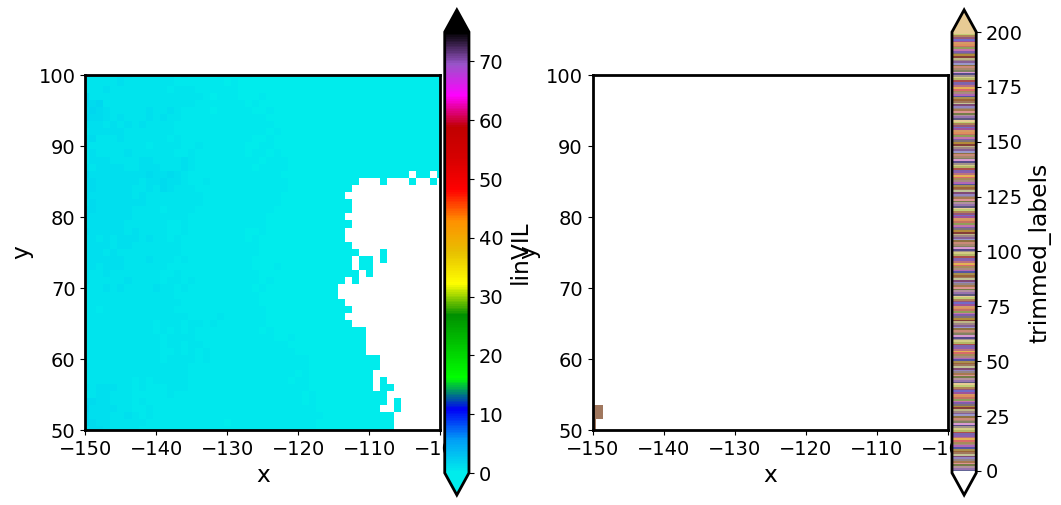

In [11]:
#plot some results
plt.rcParams.update(plt.rcParamsDefault)
#plt.style.use('dark_background')

plt.rcParams.update(
        {'font.size': 14.0,
         'axes.titlesize': 'x-large',
         'axes.linewidth': 2.0,
         'axes.labelsize': 'large'}
    )

axislabels = ["X (km)", "Y (km)"]
axisXlabels = ["X (km)", ""]
axisYlabels = ["", "Y (km)"]
axisnonelabels = ["", ""]
xlim = [-150, -100]
ylim = [50, 100]
xdiff = xlim[1] - xlim[0]
axps = xdiff * 0.075
ayps = xdiff * 0.025

fig = plt.figure(figsize=(12, 7))
object_cmap = get_obj_cmap()


ax1 = fig.add_subplot(121)
ax1.set_aspect('equal')
ax1.set_ylabel('')


vil_xy.plot(ax=ax1, x='x', y='y',
                              vmin=0.0, vmax=75.0,
                              xlim=xlim, ylim=ylim,
                              cmap='pyart_NWSRef',
                              add_colorbar=True,
        cbar_kwargs={'extend':'both', 'pad':0.01, 'label':'linVIL', 'shrink':0.9}
                                           )
ax1.set_title("")


ax2 = fig.add_subplot(122)
ax2.set_aspect('equal')
ax2.set_ylabel('')
mcit_trimmed.plot(ax=ax2, x='x', y='y',
                                           vmin=-1.0, vmax=200.0,
                                           xlim=xlim, ylim=ylim,
                                           cmap=object_cmap,
                                             add_colorbar=True,
        cbar_kwargs={'extend':'both', 'pad':0.01, 'label':'trimmed_labels', 'shrink':0.9}
                                           )
plt.show()

#out_filename = Path("./test.png")
#fig.savefig(out_filename)
plt.close(fig)

In [12]:
print(vil_xy)

<xarray.DataArray 'VIL' (y: 601, x: 601)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * x        (x) int64 -300 -299 -298 -297 -296 -295 ... 295 296 297 298 299 300
  * y        (y) int64 -300 -299 -298 -297 -296 -295 ... 295 296 297 298 299 300
    lon      (x) float64 -100.5 -100.5 -100.5 -100.4 ... -93.88 -93.87 -93.86
    lat      (y) float64 32.59 32.6 32.61 32.62 ... 37.96 37.97 37.98 37.98
Attributes:
    radar_name:       KTLX
    radar_latitude:   35.3333625793457
    radar_longitude:  -97.27776336669922
    radar_altitude:   389.0
    vcp_pattern:      212
    missing_value:    -9999.0


In [13]:
from stormcell.stormcell_helpers import create_stormcell_list

object_list = create_stormcell_list(mcit_trimmed, vil_xy)

In [14]:
from stormcell.stormcell_helpers import print_stormcell_list

print_stormcell_list(object_list)

6 size: 209.0 max: 17.269583523630118 loc: -259,-131
7 size: 83.0 max: 16.11097833239931 loc: -256,-118
10 size: 419.0 max: 15.740960409306249 loc: -251,-104
12 size: 523.0 max: 27.246226110009875 loc: -218,-64
13 size: 147.0 max: 8.79987220598075 loc: -238,-80
20 size: 756.0 max: 32.342405964014795 loc: -204,-54
21 size: 407.0 max: 21.770191261071673 loc: -216,-36
25 size: 546.0 max: 17.79441788471313 loc: -214,-26
26 size: 75.0 max: 5.632814957157544 loc: -180,-13
30 size: 329.0 max: 6.966863205099375 loc: -214,22
48 size: 1162.0 max: 14.392729491147067 loc: -201,48
57 size: 249.0 max: 6.5222222885301555 loc: -200,87
63 size: 171.0 max: 6.737122427510214 loc: -167,101
65 size: 897.0 max: 11.739494409100521 loc: -265,-139
69 size: 137.0 max: 7.204017413323168 loc: -174,119
71 size: 104.0 max: 11.852240423199811 loc: -188,134


In [15]:
from stormcell.stormcell_helpers import find_stormcell_index

index = find_stormcell_index(21, object_list)
obj = object_list[index]
print(obj.id)
print(len(obj.locs))
for i in range(len(obj.locs)):
    l = obj.locs[i]
    print("i: %d x: %d y: %d" % (i, l.x, l.y))

21
407
i: 0 x: -219 y: -43
i: 1 x: -218 y: -43
i: 2 x: -217 y: -43
i: 3 x: -216 y: -43
i: 4 x: -219 y: -42
i: 5 x: -218 y: -42
i: 6 x: -217 y: -42
i: 7 x: -216 y: -42
i: 8 x: -215 y: -42
i: 9 x: -214 y: -42
i: 10 x: -213 y: -42
i: 11 x: -220 y: -41
i: 12 x: -219 y: -41
i: 13 x: -218 y: -41
i: 14 x: -217 y: -41
i: 15 x: -216 y: -41
i: 16 x: -215 y: -41
i: 17 x: -214 y: -41
i: 18 x: -213 y: -41
i: 19 x: -220 y: -40
i: 20 x: -219 y: -40
i: 21 x: -218 y: -40
i: 22 x: -217 y: -40
i: 23 x: -216 y: -40
i: 24 x: -215 y: -40
i: 25 x: -214 y: -40
i: 26 x: -213 y: -40
i: 27 x: -223 y: -39
i: 28 x: -222 y: -39
i: 29 x: -221 y: -39
i: 30 x: -220 y: -39
i: 31 x: -219 y: -39
i: 32 x: -218 y: -39
i: 33 x: -217 y: -39
i: 34 x: -216 y: -39
i: 35 x: -215 y: -39
i: 36 x: -214 y: -39
i: 37 x: -213 y: -39
i: 38 x: -212 y: -39
i: 39 x: -211 y: -39
i: 40 x: -224 y: -38
i: 41 x: -223 y: -38
i: 42 x: -222 y: -38
i: 43 x: -221 y: -38
i: 44 x: -220 y: -38
i: 45 x: -219 y: -38
i: 46 x: -218 y: -38
i: 47 x: -217 y:

In [16]:
#
#Sort objects by size:
#
# Sort the list of objects by the 'age' attribute
objects_sorted_by_size = sorted(object_list, key=lambda objects: len(objects.locs) )
objects_sorted_by_size.reverse()
print_stormcell_list(objects_sorted_by_size)

48 size: 1162.0 max: 14.392729491147067 loc: -201,48
65 size: 897.0 max: 11.739494409100521 loc: -265,-139
20 size: 756.0 max: 32.342405964014795 loc: -204,-54
25 size: 546.0 max: 17.79441788471313 loc: -214,-26
12 size: 523.0 max: 27.246226110009875 loc: -218,-64
10 size: 419.0 max: 15.740960409306249 loc: -251,-104
21 size: 407.0 max: 21.770191261071673 loc: -216,-36
30 size: 329.0 max: 6.966863205099375 loc: -214,22
57 size: 249.0 max: 6.5222222885301555 loc: -200,87
6 size: 209.0 max: 17.269583523630118 loc: -259,-131
63 size: 171.0 max: 6.737122427510214 loc: -167,101
13 size: 147.0 max: 8.79987220598075 loc: -238,-80
69 size: 137.0 max: 7.204017413323168 loc: -174,119
71 size: 104.0 max: 11.852240423199811 loc: -188,134
7 size: 83.0 max: 16.11097833239931 loc: -256,-118
26 size: 75.0 max: 5.632814957157544 loc: -180,-13


In [17]:
objects_sorted_by_max = sorted(object_list, key=lambda objects: objects.max_value)
objects_sorted_by_max.reverse()
print_stormcell_list(objects_sorted_by_max)

20 size: 756.0 max: 32.342405964014795 loc: -204,-54
12 size: 523.0 max: 27.246226110009875 loc: -218,-64
21 size: 407.0 max: 21.770191261071673 loc: -216,-36
25 size: 546.0 max: 17.79441788471313 loc: -214,-26
6 size: 209.0 max: 17.269583523630118 loc: -259,-131
7 size: 83.0 max: 16.11097833239931 loc: -256,-118
10 size: 419.0 max: 15.740960409306249 loc: -251,-104
48 size: 1162.0 max: 14.392729491147067 loc: -201,48
71 size: 104.0 max: 11.852240423199811 loc: -188,134
65 size: 897.0 max: 11.739494409100521 loc: -265,-139
13 size: 147.0 max: 8.79987220598075 loc: -238,-80
69 size: 137.0 max: 7.204017413323168 loc: -174,119
30 size: 329.0 max: 6.966863205099375 loc: -214,22
63 size: 171.0 max: 6.737122427510214 loc: -167,101
57 size: 249.0 max: 6.5222222885301555 loc: -200,87
26 size: 75.0 max: 5.632814957157544 loc: -180,-13
